# Compound structure lookup

In [1]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

## Get SMILES and parent_cmpd_chemblid

See notebook [02_Map_ChEMBL_targets_and_get_curve_data](02_Map_ChEMBL_targets_and_get_curve_data.ipynb#get_curve_data) for details on how data table '`tt_curve_data_v2`' was created. It is used here as it subsumes table '`tt_curve_data_v1`'.

In [2]:
tt_structure_lookup = pd.read_sql_query("""
    select distinct
          parent_cmpd_chemblid as cmpd
        , smiles
        , amw
        , nat
    from
        tt_curve_data_v2
    order by
        parent_cmpd_chemblid
""", engine)

tt_structure_lookup.shape

(263626, 4)

## Add molecules

In [3]:
# Add molecules...

PandasTools.AddMoleculeColumnToFrame(tt_structure_lookup, smilesCol='smiles', molCol='mol')

In [4]:
# Check for failures to build a molecule...

failed = tt_structure_lookup['mol'].isnull()

sum(failed)

6

In [5]:
# Inspect failures...

tt_structure_lookup[failed]

,cmpd,smiles,amw,nat,mol
7494,CHEMBL1161633,OCl(=O)=O,84.46,4,None
7496,CHEMBL1161635,OBr(=O)=O,128.91,4,None
7498,CHEMBL1161637,OI(=O)(=O)=O,191.91,5,None
144981,CHEMBL181124,F[P-](F)(F)(F)(F)F,144.96,7,None
151011,CHEMBL1906899,OCl=O,68.46,3,None
235724,CHEMBL450200,CC1=NC2=N(=NC=N2)C(=C1)OCCCN(CC(c3ccccc3)c4ccccc4)Cc5cccc(c5Cl)C(F)(F)F,580.04,41,None


In [6]:
# Remove failed records...

tt_structure_lookup = tt_structure_lookup[~failed].reset_index(drop=True)

tt_structure_lookup.shape

(263620, 5)

## Add USMILES

In [7]:
# Add USMILES...
    
tt_structure_lookup['usmiles'] = tt_structure_lookup['mol'].apply(lambda x: Chem.MolToSmiles(x) if x else None)

tt_structure_lookup.shape

(263620, 6)

In [8]:
failed = tt_structure_lookup['usmiles'].isnull()

sum(failed)

0

## Add Murko Scaffolds

In [9]:
# Add Murko Scaffolds...

PandasTools.AddMurckoToFrame(tt_structure_lookup, molCol='mol', MurckoCol='core_smiles', Generic=False)

tt_structure_lookup.shape

(263620, 7)

In [10]:
failed = tt_structure_lookup['core_smiles'].isnull()

sum(failed)

0

,cmpd,smiles,amw,nat,mol,usmiles,core_smiles
0,CHEMBL1,COc1ccc2[C@@H]3[C@H](COc2c1)C(C)(C)OC4=C3C(=O)C(=O)C5=C4OC(C)(C)[C@@H]6COc7cc(OC)ccc7[C@H]56,544.59,40,,COc1ccc2c(c1)OCC1C2C2=C(OC1(C)C)C1=C(C(=O)C2=O)C2c3ccc(OC)cc3OCC2C(C)(C)O1,O=C1C(=O)C2=C(OCC3COc4ccccc4C23)C2=C1C1c3ccccc3OCC1CO2

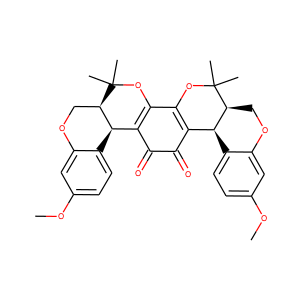

In [11]:
tt_structure_lookup.head(1)

## Save table

In [12]:
# Save locally...

tt_structure_lookup.to_pickle('tt_structure_lookup.pkl')

In [22]:
# Write to RDBMS...

tt_structure_lookup[['cmpd', 'smiles', 'amw', 'nat', 'usmiles', 'core_smiles']].to_sql('tt_structure_lookup', engine, dtype={
    'cmpd':        VARCHAR2(20),
    'smiles':      VARCHAR2(4000),
    'amw':         NUMBER(9, 2),
    'nat':         NUMBER(3, 0),
    'usmiles':     VARCHAR2(4000),
    'core_smiles': VARCHAR2(4000),
}, if_exists='replace', index=False)

# Add indexes...

for col in ['cmpd', 'smiles', 'usmiles']: engine.execute("create index {}_idx on tt_structure_lookup({})".format(*[col]*2))

## Checks

In [23]:
engine.execute("select count(*) n from tt_structure_lookup").fetchone()[0]

263620

In [24]:
%%time

df = pd.read_sql_table('tt_structure_lookup', engine)

CPU times: user 5.77 s, sys: 331 ms, total: 6.1 s
Wall time: 8.79 s


In [25]:
df.shape

(263620, 6)

In [26]:
df['cmpd'].unique().size

263620

As expected, `parent_cmpd_chemblid` is unique.

In [27]:
df['smiles'].unique().size

263558

The SMILES cound is slightly smaller than the `parent_cmpd_chemblid` count (which corresponds to InChIs) as some compounds (e.g. -N=N-) cannot have their stereochemistry represented in SMILES, so multiple stereoisomers give degenerate SMILES.

In [28]:
df['usmiles'].unique().size

253617

Count for unique USMILES is smaller as expected.